In [1]:
import os
#!pip install -U numpy
#os.environ['KMP_DUPLICATE_LIB_OK']='True'
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
data = pd.read_csv("spring/total.csv",encoding='utf-8')

In [4]:
data["categorias"] = data["categorias"].apply(
    lambda x: literal_eval(x)
)
data["categorias"].values[:5]

array([list(['Engineering', 'Computational Intelligence', 'Artificial Intelligence']),
       list(['Engineering', 'Computational Intelligence', 'Artificial Intelligence']),
       list(['Engineering', 'Computational Intelligence', 'Artificial Intelligence', 'Professional Computing']),
       list(['Engineering', 'Computational Intelligence', 'Control, Robotics, Mechatronics', 'Artificial Intelligence']),
       list(['Computer Science', 'Computer Systems Organization and Communication Networks', 'Communications Engineering, Networks', 'Wireless and Mobile Communication'])],
      dtype=object)

In [5]:
test_split = 0.2

# Initial train and test split.
train_df, test_df = train_test_split(
    data,
    test_size=test_split,
    stratify=data["categorias"].values,
)
# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

In [6]:
terms = tf.ragged.constant(train_df["categorias"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'Engineering', 'Artificial Intelligence', 'Computational Intelligence', 'Communications Engineering, Networks', 'Computer Science', 'Cyber-physical systems, IoT', 'Professional Computing', 'Machine Learning', 'Control, Robotics, Mechatronics', 'Data Structures and Information Theory', 'Science, Humanities and Social Sciences, multidisciplinary', 'Data Engineering', 'Industrial and Production Engineering', 'Mechanical Engineering', 'Computer Communication Networks', 'Medicine & Public Health', 'Signal, Image and Speech Processing', 'Statistics, general', 'Computer Imaging, Vision, Pattern Recognition and Graphics', 'Computer Science, general', 'Data Mining and Knowledge Discovery', 'Robotics and Automation', 'Business and Management', 'Mobile and Network Security', 'Manufacturing, Machines, Tools, Processes', 'Science, multidisciplinary', 'Biomedical Engineering and Bioengineering', 'Science and Technology Studies', 'Image Processing and Computer Vision', 'Mathema

In [7]:
sample_label = train_df["categorias"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['Engineering', 'Communications Engineering, Networks', 'Wireless and Mobile Communication', 'Computational Intelligence', 'Artificial Intelligence', 'Data Engineering', 'Computer Systems Organization and Communication Networks']
Label-binarized representation: [[0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [8]:
train_df["abstract"].apply(lambda x: len(x.split(" "))).describe()

count    11077.000000
mean       111.890223
std         48.403966
min          1.000000
25%         82.000000
50%        109.000000
75%        138.000000
max       1029.000000
Name: abstract, dtype: float64

In [9]:
max_seqlen = 139
batch_size = 500
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["categorias"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["abstract"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [10]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [11]:
next(iter(train_dataset))

(<tf.Tensor: shape=(200,), dtype=string, numpy=
 array([b'biological age indicator functional condition individual\xe2\x80\x99s body unlike chronological age measures time birth biological age human also affected medical condition life habits sociodemographic variables well biomarkers taking advantage statistical concept depth serves measurement degree centrality multivariate observation respect dataset assess biological age individual chronological age would make selected records deep possible compared individuals chronological age similar direct conclusions imputation technique presented',
        b'laboratory experiments important pedagogical tools engineering courses restrictions related covid- pandemic made difficult impossible laboratory classes take place resulting fast transition simulation approach guarantee effectiveness teaching simulation environments powerful tools adopted remote classes self-study tools students perform experiments cases make use laboratory facilities out

In [12]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:3]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'optimal cascade reservoir scheduling complex problem related broad interests society economy environment study proposes solution dispatching cascade reservoir operation optimization based multi-objective water cycle algorithm (mwca) search strategies confluence diversion seepage evaporation rainfall established mwca simulating natural water cycle process relative gravity mechanism multi-objective constructed achieve adequate search optimal solutions simulation section calculation results proposed approach compared methods literature eg particle swarm optimization (mopso) genetic algorithm (nsga-ii) compared results show mwca superior algorithms calculation diversity effective solution multi-objective optimal scheduling problem cascade reservoir groups'
Label(s): ['Engineering' 'Mechanical Engineering'
 'Mathematical and Computational Engineering' 'Electrical Engineering']
 
Abstract: b'species distribution models provide habitat mapping tools produce scalable information in

In [13]:
# Source: https://stackoverflow.com/a/18937309/7636462
vocabulary = set()
train_df["abstract"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print( vocabulary_size)

73234


In [14]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [15]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [

            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
            #layers.Dense( len(vocab), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model



def make_model():
    shallow_mlp_model = tf.keras.models.Sequential([
        layers.Dense(512, activation="relu"),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')
        ])
    return shallow_mlp_model

In [16]:
epochs = 20
#5 para acelerar las primeras versiones, solo queremos ver que no explota
opt = tf.optimizers.Adam()
shallow_mlp_model = make_model()
shallow_mlp_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy","binary_accuracy"])
#categorical_crossentropy
#sparse_categorical_crossentropy

In [17]:
history = shallow_mlp_model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs)

Epoch 1/20
56/56 [==============================] - 9s 150ms/step - loss: 1186.6326 - accuracy: 0.5288 - binary_accuracy: 0.2620 - val_loss: 5946.1045 - val_accuracy: 0.5834 - val_binary_accuracy: 0.0652
Epoch 2/20
56/56 [==============================] - 11s 188ms/step - loss: 35370.2422 - accuracy: 0.5554 - binary_accuracy: 0.0234 - val_loss: 102998.9453 - val_accuracy: 0.5834 - val_binary_accuracy: 0.0069
Epoch 3/20
56/56 [==============================] - 11s 186ms/step - loss: 244323.7500 - accuracy: 0.5554 - binary_accuracy: 0.0068 - val_loss: 460100.1250 - val_accuracy: 0.5834 - val_binary_accuracy: 0.0069
Epoch 4/20
56/56 [==============================] - 11s 188ms/step - loss: 785880.5625 - accuracy: 0.5554 - binary_accuracy: 0.0068 - val_loss: 1290880.5000 - val_accuracy: 0.5834 - val_binary_accuracy: 0.0069
Epoch 5/20
56/56 [==============================] - 10s 177ms/step - loss: 1775680.5000 - accuracy: 0.5554 - binary_accuracy: 0.0068 - val_loss: 2626019.2500 - val_accur

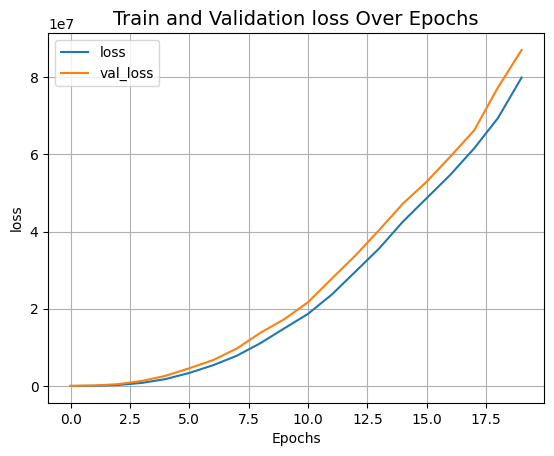

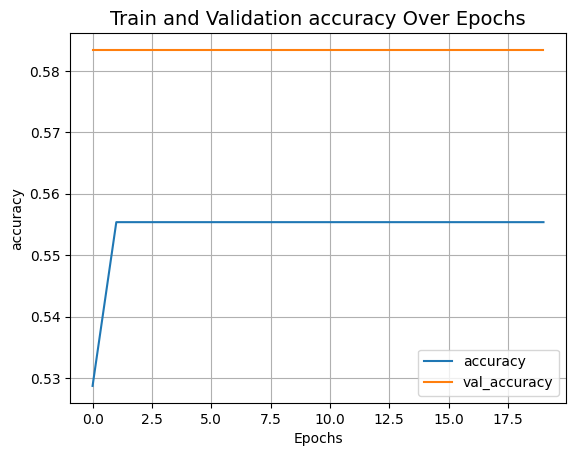

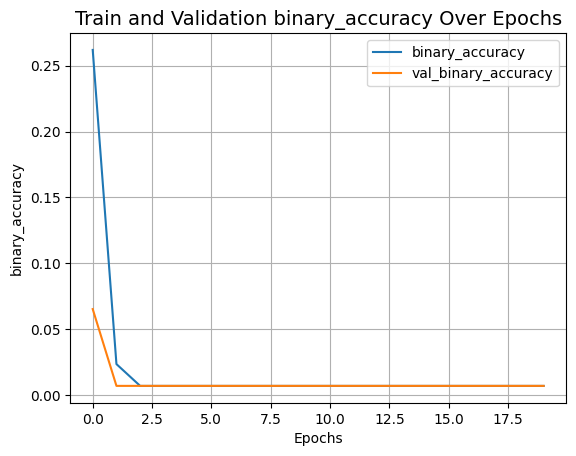

In [18]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")
plot_result("binary_accuracy")

In [19]:
keras.models.save_model(shallow_mlp_model,'spring/radEd_model_v2.hdf5')
#shallow_mlp_model = tf.keras.models.load_model('spring/radEd_model_v2.hdf5')

ImportError: `save_model()` using h5 format requires h5py. Could not import h5py.

In [20]:
_,accura, binary_acc  = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")
print(f"Categorical accuracy on the test set: {round(accura * 100, 2)}%.")

7/7 [==============================] - 0s 38ms/step - loss: 88153104.0000 - accuracy: 0.5509 - binary_accuracy: 0.0068
Categorical accuracy on the test set: 0.68%.
Categorical accuracy on the test set: 55.09%.


In [21]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:10]):
    label = label_batch[i].numpy()[None, ...]
    #print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

4/4 [==============================] - 0s 13ms/step
Label(s): ['Earth Sciences' 'Computer Applications' 'Geography, general' 'Ecology'
 'Water, general' 'Oceanography' 'Pollution, general']
Predicted Label(s): (Engineering, Artificial Intelligence, Computational Intelligence)
 
Label(s): ['Engineering' 'Artificial Intelligence' 'Computational Intelligence'
 'Data Structures and Information Theory'
 'Computer Imaging, Vision, Pattern Recognition and Graphics']
Predicted Label(s): (Engineering, Artificial Intelligence, Computational Intelligence)
 
Label(s): ['Physics' 'Particle and Nuclear Physics' 'Nuclear Energy'
 'Nuclear Physics, Heavy Ions, Hadrons']
Predicted Label(s): (Engineering, Artificial Intelligence, Computational Intelligence)
 
Label(s): ['Engineering' 'Artificial Intelligence' 'Control, Robotics, Mechatronics'
 'Mathematical and Computational Engineering' 'Bioinformatics'
 'Applications of Mathematics' 'Statistical Physics and Dynamical Systems']
Predicted Label(s): (Eng

In [ ]:

[
        x
        for  x in sorted(
            zip(predicted_probabilities[60], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:6]